![image.png](https://i.imgur.com/a3uAqnb.png)

# **📌 Working with Different Dataset Structures**
---

## **Purpose of This Lab**

In real-world projects, datasets don't always come in the same format:
- Some are **pre-split** into train/validation/test folders
- Others are **unsplit**, requiring you to create splits manually
- Some include **CSV files** with labels, while others use **folder-based labels**
- Segmentation datasets have **paired images and masks** instead of class labels
- Plotting some

**This lab trains you to:**
1. **Inspect and understand** different dataset structures
2. **Build custom Dataset classes** for various data formats
3. **Handle both classification and segmentation** datasets
4. **Debug and visualize** data before training

By the end of this lab, you will be confident working with any dataset structure you encounter.

---

## **What We Will Cover**

### **Part 1: Image Classification Datasets**
- Pre-split datasets (train/val/test folders already separated)
- Unsplit datasets (all images in one folder, requiring manual splitting)
- CSV-based datasets (labels stored in a CSV file)

### **Part 2: Image Segmentation Datasets**
- Binary segmentation (masks with 2 classes: foreground/background)
- Multi-class segmentation (masks with multiple object classes)
- Understanding image-mask pairs

✅ Debugging dataset loading issues

In [ ]:
# Uncomment these lines if running on Google Colab
# import os
# os.environ["KAGGLEHUB_CACHE"] = "/content/data"

---

# **Part 1: Image Classification Datasets**

In this section, we'll work with **three types** of classification dataset structures:

1. **Pre-split dataset** - Already divided into train/validation/test folders
2. **Unsplit dataset** - All images in one folder, needs manual splitting
3. **CSV-labeled dataset** - Labels stored in a CSV file instead of folder names

We'll build a **complete example** for the first type, then leave the others as exercises.

## **Example 1: Pre-Split Dataset (Train/Val/Test)**

**Dataset:** Fruit and Vegetable Image Recognition  
**Structure:** Images are already organized into `train/`, `validation/`, and `test/` folders

This is the **easiest** type to work with because the data is already split for us.

In [1]:
# Import required libraries
import os
import kagglehub
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

## Fruits and Vegetables Image Recognition Dataset

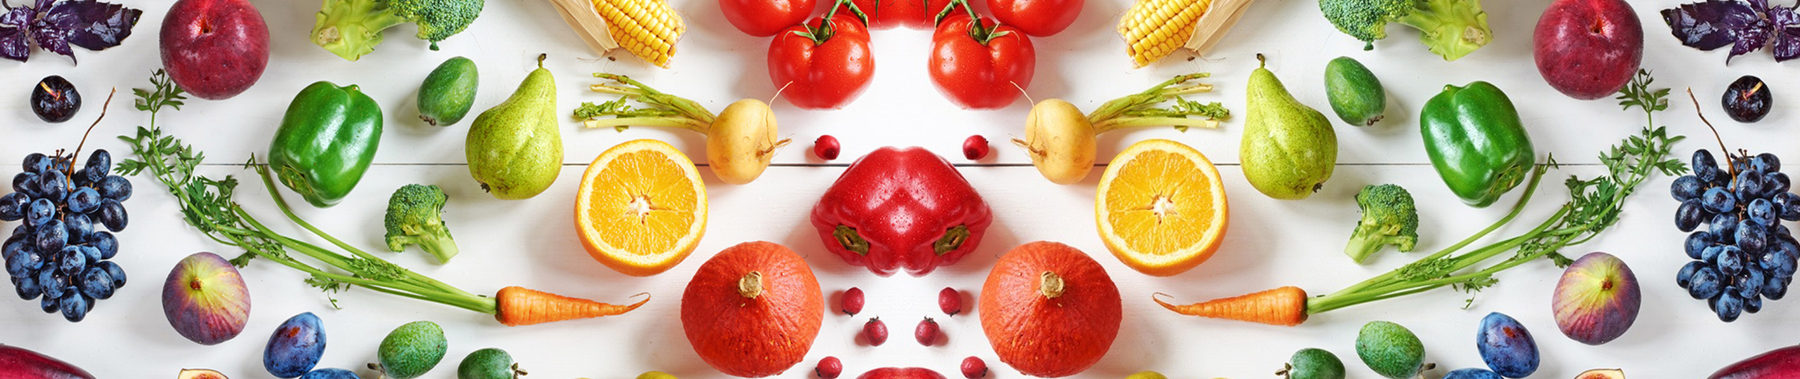

In [2]:
# Download the dataset from Kaggle
path = kagglehub.dataset_download("kritikseth/fruit-and-vegetable-image-recognition")
print("Dataset downloaded to:", path)

Using Colab cache for faster access to the 'fruit-and-vegetable-image-recognition' dataset.
Dataset downloaded to: /kaggle/input/fruit-and-vegetable-image-recognition


### **Step 1: Inspect the Dataset Structure**

Before writing any code, **always** inspect the dataset structure first.  
This helps you understand:
- How folders are organized
- Where images are located
- How labels are defined (folder names, CSV, etc.)

In [3]:
# Let's look inside the 'train' folder
train_path = os.path.join(path, "train")

print(f"\nClasses in train folder (first 10):")
classes = sorted(os.listdir(train_path))
for i, class_name in enumerate(classes[:10]):
    class_path = os.path.join(train_path, class_name)
    num_images = len(os.listdir(class_path))
    print(f"  {i}: {class_name} - {num_images} images")

print(f"\nTotal classes: {len(classes)}")


Classes in train folder (first 10):
  0: apple - 68 images
  1: banana - 75 images
  2: beetroot - 88 images
  3: bell pepper - 90 images
  4: cabbage - 92 images
  5: capsicum - 89 images
  6: carrot - 82 images
  7: cauliflower - 79 images
  8: chilli pepper - 87 images
  9: corn - 87 images

Total classes: 36


In [4]:
# List the contents of the dataset directory
print("Top-level contents:")
for item in os.listdir(path):
    item_path = os.path.join(path, item)
    if os.path.isdir(item_path):
        print(f"📁 {item}/")
    else:
        print(f"📄 {item}")

Top-level contents:
📁 validation/
📁 test/
📁 train/


**What we discovered:**
- ✅ Folders: `train/`, `validation/`, `test/`
- ✅ Each folder contains subfolders named by class (e.g., `apple`, `banana`)
- ✅ Each class subfolder contains images of that class
- ✅ **Labels come from folder names** - this is called "folder-based labeling"

**Key Insight:** The folder structure **IS** the labeling system.

### **Step 2: Build a Custom Dataset Class**

Now that we understand the structure, we need to create a **PyTorch Dataset class**.

**Why do we need a custom Dataset class?**
- PyTorch's `DataLoader` needs a standardized way to access data
- The Dataset class defines **how to load one sample** (image + label)
- It allows PyTorch to efficiently batch, shuffle, and load data in parallel

**Required Methods:**
1. `__init__()` - Initialize the dataset (scan folders, collect file paths)
2. `__len__()` - Return total number of samples
3. `__getitem__(idx)` - Load and return one sample at index `idx`

In [5]:
class FruitVegetableDataset(Dataset):
    """
    Custom Dataset for pre-split folder-based image classification.
    
    Expected structure:
        root/
            class1/
                img1.jpg
                img2.jpg
            class2/
                img3.jpg
    """
    
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (str): Path to the dataset folder (e.g., 'path/train')
            transform: Optional torchvision transforms to apply
        """
        self.root_dir = root_dir
        self.transform = transform
        
        # Step 1: Get all class names (folder names)
        self.classes = sorted(os.listdir(root_dir))
        
        # Step 2: Create a mapping from class name to integer label
        self.class_to_idx = {class_name: i for i, class_name in enumerate(self.classes)}
        
        # Step 3: Collect all image paths and their labels
        self.image_paths = []
        self.labels = []
        
        for class_name in self.classes:
            class_dir = os.path.join(root_dir, class_name)
            class_idx = self.class_to_idx[class_name]
            
            # Get all image files in this class folder
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                self.image_paths.append(img_path)
                self.labels.append(class_idx)
    
    def __len__(self):
        """Return the total number of samples"""
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        """
        Load and return one sample.
        
        Args:
            idx (int): Index of the sample to load
            
        Returns:
            tuple: (image, label)
        """
        # Load image
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')  # Ensure RGB format
        
        # Get label
        label = self.labels[idx]
        
        # Apply transforms if provided
        if self.transform:
            image = self.transform(image)
        
        return image, label

**Why is the Dataset class structured this way?**

1. **`__init__()` scans the dataset once:**
   - Builds lists of all image paths and labels
   - This is done **once** when creating the dataset, not every time we access a sample
   - Makes subsequent access very fast

2. **`__len__()` enables batching:**
   - DataLoader needs to know how many samples exist
   - Used to determine number of batches

3. **`__getitem__()` loads one sample on-demand:**
   - Called by DataLoader when creating batches
   - Loads image from disk **only when needed** (memory efficient)
   - Applies transforms (augmentation, normalization)

4. **Why convert to RGB?**
   - Some images might be grayscale or have alpha channel
   - `.convert('RGB')` ensures all images have 3 channels

In [6]:
# Create datasets for train, validation, and test
train_dataset = FruitVegetableDataset(
    root_dir=os.path.join(path, "train"),
    transform=transforms.ToTensor()
)

val_dataset = FruitVegetableDataset(
    root_dir=os.path.join(path, "validation"),
    transform=transforms.ToTensor()
)

test_dataset = FruitVegetableDataset(
    root_dir=os.path.join(path, "test"),
    transform=transforms.ToTensor()
)

print(f"Train samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Number of classes: {len(train_dataset.classes)}")
print(f"Classes: {train_dataset.classes[:5]}...")  # Show first 5 classes

Train samples: 3115
Validation samples: 351
Test samples: 359
Number of classes: 36
Classes: ['apple', 'banana', 'beetroot', 'bell pepper', 'cabbage']...


### **Step 3: Visualize Dataset Samples**

Before training, it's **crucial** to visualize your data to ensure:
- Images are loading correctly
- Labels match the images
- Images are the expected size and format
- No corrupted or mislabeled data

Let's plot a few random samples from our training dataset.

In [7]:
import random
import numpy as np

# Create a function to visualize samples
def visualize_samples(dataset, num_samples=8, title="Dataset Samples"):
    """
    Visualize random samples from a dataset.
    
    Args:
        dataset: PyTorch Dataset object
        num_samples: Number of samples to display
        title: Title for the plot
    """
    # Select random indices
    indices = random.sample(range(len(dataset)), num_samples)
    
    # Calculate grid size
    cols = 4
    rows = (num_samples + cols - 1) // cols
    
    # Create the plot
    fig, axes = plt.subplots(rows, cols, figsize=(12, 3 * rows))
    axes = axes.flatten()
    
    for i, idx in enumerate(indices):
        # Get image and label
        image, label = dataset[idx]
        # Convert tensor to numpy for display
        if isinstance(image, torch.Tensor):
            image = image.permute(1, 2, 0).numpy()  # CHW -> HWC
        # Get class name
        class_name = dataset.classes[label]
        # Display image
        axes[i].imshow(image)
        axes[i].set_title(f"{class_name}\n(Label: {label})", fontsize=10)
        axes[i].axis('off')
    # Hide any unused subplots
    for i in range(num_samples, len(axes)):
        axes[i].axis('off')
    
    plt.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


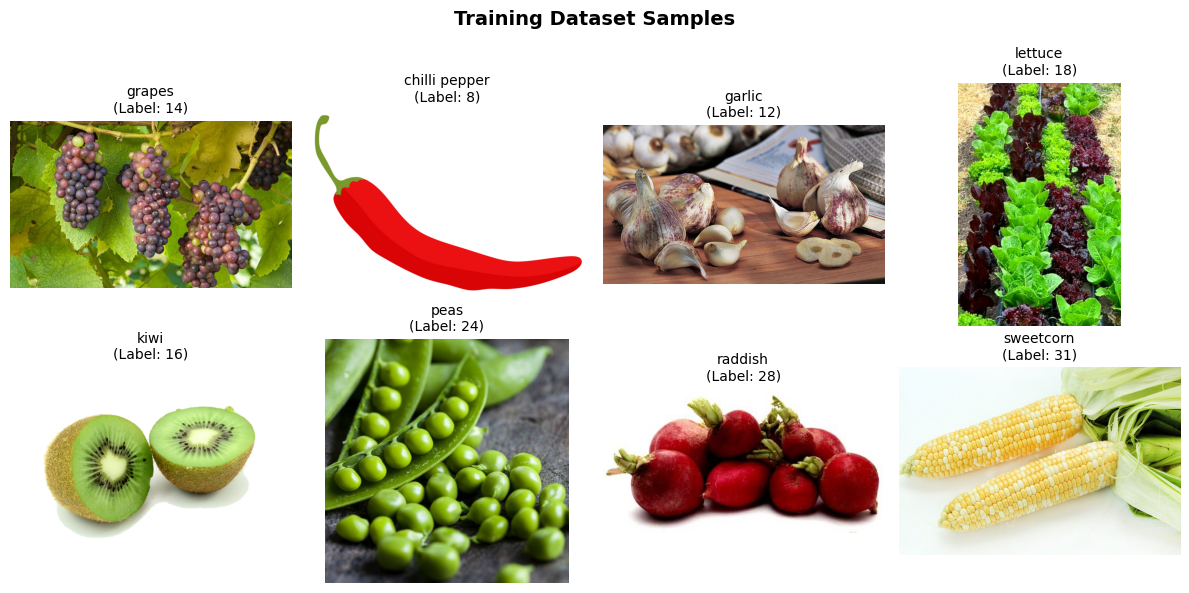

In [ ]:

# Visualize training samples
visualize_samples(train_dataset, num_samples=8, title="Training Dataset Samples")

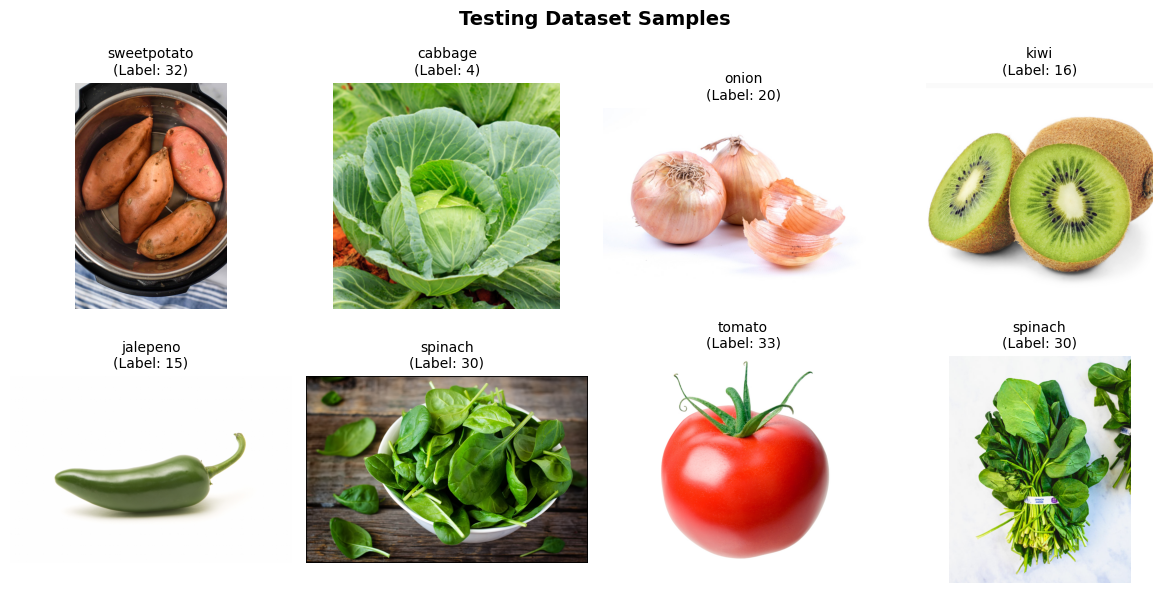

In [9]:

# Visualize Testing samples
visualize_samples(test_dataset, num_samples=8, title="Testing Dataset Samples")

In [11]:
# Let's examine a single sample in detail
sample_idx = 0
image, label = train_dataset[sample_idx]

print(f"Image shape: {image.shape}")
print(f"Label: {label}")
print(f"Class name: {train_dataset.classes[label]}")

Image shape: torch.Size([3, 4965, 4900])
Label: 0
Class name: apple


## Tire Texture Image Recognition

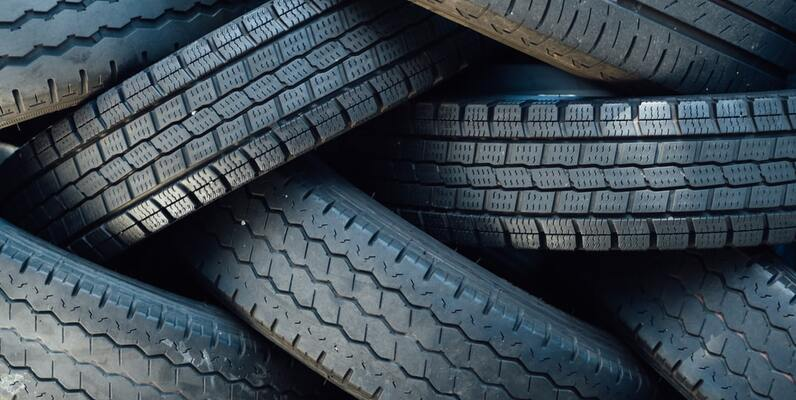

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jehanbhathena/tire-texture-image-recognition")        # Data Classified into train, test

print("Path to dataset files:", path)

100%|██████████| 708M/708M [00:10<00:00, 70.6MB/s]

Extracting files...


Path to dataset files: /content/data/datasets/jehanbhathena/tire-texture-image-recognition/versions/1


# TO-DO :)

## **Example 2: CSV-Labeled Dataset (Unsplit)**

**Dataset:** 20 Fonts Classification  
**Structure:** All images in one folder + CSV file with labels

**Challenges:**
- Labels are in a CSV file, not folder names
- Data is **not split** - we need to create train/val/test splits manually
- Need to parse CSV to map images to labels

This is more complex but very common in real-world datasets.

## 20 Fonts Classification

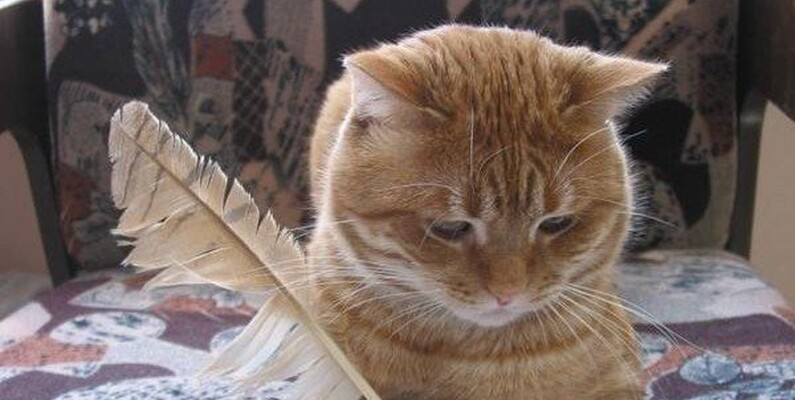

In [15]:
import kagglehub

# Download latest version
fonts_path = kagglehub.dataset_download("samoilovmikhail/20-fonts-classification")            # Data given in one folder unsplitted + csv

print("Path to dataset files:", path)

Using Colab cache for faster access to the '20-fonts-classification' dataset.
Path to dataset files: /kaggle/input/20-fonts-classification


### **Step 1: Inspect the Dataset Structure**

With CSV-based datasets, we need to:
1. Find the CSV file location
2. Understand the CSV format (columns, headers)
3. Locate the images folder
4. Check if images match the CSV entries

In [16]:
# Explore the dataset structure
print("Top-level contents:")
for item in os.listdir(fonts_path):
    item_path = os.path.join(fonts_path, item)
    if os.path.isdir(item_path):
        num_files = len(os.listdir(item_path))
        print(f"📁 {item}/ - {num_files} files")
    else:
        print(f"📄 {item}")

Top-level contents:
📁 files/ - 20000 files
📄 metadata.csv


In [18]:
import pandas as pd

# Find and load the CSV file
csv_files = [f for f in os.listdir(fonts_path) if f.endswith('.csv')]
print(f"CSV files found: {csv_files}\n")

# Load the CSV
csv_path = os.path.join(fonts_path, csv_files[0])
df = pd.read_csv(csv_path)

print(f"CSV shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}\n")
print("First 10 rows:")
print(df.head(10))

print(f"\nUnique labels: {df['Font'].nunique()}")
print(f"Label distribution:\n{df['Font'].value_counts().head(10)}")

CSV files found: ['metadata.csv']

CSV shape: (20000, 3)
Columns: ['FileName', 'Font', 'Text']

First 10 rows:
      FileName           Font      Text
0   file_1.png     CourierNew  Sediment
1   file_2.png          Arial     Guest
2   file_3.png  CenturyGothic    Socket
3   file_4.png        Verdana     Onset
4   file_5.png        Candara    Driver
5   file_6.png  TimesNewRoman   Oakland
6   file_7.png       Garamond     Breed
7   file_8.png  TimesNewRoman   Garrett
8   file_9.png       Palatino      Tens
9  file_10.png        Calibri      Arts

Unique labels: 20
Label distribution:
Font
CourierNew       1000
Arial            1000
CenturyGothic    1000
Verdana          1000
Candara          1000
TimesNewRoman    1000
Garamond         1000
Palatino         1000
Calibri          1000
Lobster          1000
Name: count, dtype: int64


**What we discovered:**
- ✅ CSV file contains `image` (filename) and `label` (class name) columns
- ✅ All images are in a single `data/` folder (not split by class)
- ✅ The dataset is **unsplit** - we'll need to create train/val/test splits
- ✅ Multiple fonts (classes) are represented

**Key Differences from Example 1:**
- Labels come from CSV, not folder structure
- Need to manually split the data
- All images mixed together in one folder

### **Step 2: Build a Custom Dataset Class for CSV-Based Data**

This Dataset class is different because:
1. **Reads labels from CSV** instead of folder names
2. **Supports train/val/test splitting** using indices
3. **No class folders** - all images in one location

We'll use `train_test_split` from scikit-learn to create splits.

In [ ]:
from sklearn.model_selection import train_test_split

class CSVDataset(Dataset):
    """
    Custom Dataset for CSV-labeled images.
    
    Expected structure:
        root/
            data/
                img1.jpg
                img2.jpg
            labels.csv (with 'image' and 'label' columns)
    """
    
    def __init__(self, root_dir, csv_file, split='train', train_ratio=0.7, val_ratio=0.15, 
                 transform=None, random_state=42):
        """
        Args:
            root_dir (str): Path to dataset folder
            csv_file (str): Name of the CSV file
            split (str): 'train', 'val', or 'test'
            train_ratio (float): Proportion of data for training
            val_ratio (float): Proportion of data for validation
            transform: Optional transforms to apply
            random_state (int): Random seed for reproducible splits
        """
        self.root_dir = root_dir
        self.transform = transform
        
        # Load CSV
        csv_path = os.path.join(root_dir, csv_file)
        df = pd.read_csv(csv_path)
        
        # Get unique classes and create mapping
        self.classes = sorted(df['Font'].unique())
        self.class_to_idx = {class_name: i for i, class_name in enumerate(self.classes)}
        
        # Convert labels to indices
        df['label_idx'] = df['Font'].map(self.class_to_idx)
        
        # Split data into train/val/test
        train_df, temp_df = train_test_split(
            df, test_size=(1 - train_ratio), random_state=random_state, stratify=df['Font']
        )
        
        # Split temp into val and test
        val_size = val_ratio / (1 - train_ratio)  # Adjust ratio for remaining data
        val_df, test_df = train_test_split(
            temp_df, test_size=(1 - val_size), random_state=random_state, stratify=temp_df['Font']
        )
        
        # Select the appropriate split
        if split == 'train':
            self.data = train_df.reset_index(drop=True)
        elif split == 'val':
            self.data = val_df.reset_index(drop=True)
        elif split == 'test':
            self.data = test_df.reset_index(drop=True)
        else:
            raise ValueError("split must be 'train', 'val', or 'test'")
        
        # Determine images folder (usually 'data' or similar)
        self.images_folder = 'files'  # Adjust based on actual folder name
        
    def __len__(self):
        """Return the total number of samples in this split"""
        return len(self.data)
    
    def __getitem__(self, idx):
        """
        Load and return one sample.
        
        Args:
            idx (int): Index of the sample
            
        Returns:
            tuple: (image, label)
        """
        # Get image filename and label
        # Use the first column (index 0) which contains the image filenames
        img_name = self.data.iloc[idx, 0]  # First column contains filenames
        label = self.data.iloc[idx]['label_idx']
        
        # Load image
        img_path = os.path.join(self.root_dir, self.images_folder, img_name)
        image = Image.open(img_path).convert('RGB')
        
        # Apply transforms
        if self.transform:
            image = self.transform(image)
        
        return image, label

**Key differences from the folder-based Dataset:**

1. **CSV Loading:**
   - Reads labels from CSV file instead of folder structure
   - Creates `class_to_idx` mapping from unique labels in CSV

2. **Data Splitting:**
   - Uses `train_test_split` with **stratification** (maintains class distribution)
   - Splits happen **inside** `__init__` based on the `split` parameter
   - Same CSV file used for all splits, but different rows are selected

3. **File Path Construction:**
   - Must specify `images_folder` since all images are together
   - Combines `root_dir + images_folder + filename` to get full path

4. **Why Stratified Split?**
   - Ensures each class appears proportionally in train/val/test
   - Prevents train set from having all samples of certain classes

In [27]:
# Create train, validation, and test datasets from the same CSV
fonts_train_dataset = CSVDataset(
    root_dir=fonts_path,
    csv_file=csv_files[0],
    split='train',
    train_ratio=0.7,
    val_ratio=0.15,
    transform=transforms.ToTensor(),
    random_state=42
)

fonts_val_dataset = CSVDataset(
    root_dir=fonts_path,
    csv_file=csv_files[0],
    split='val',
    train_ratio=0.7,
    val_ratio=0.15,
    transform=transforms.ToTensor(),
    random_state=42  # Same seed ensures consistent splits
)

fonts_test_dataset = CSVDataset(
    root_dir=fonts_path,
    csv_file=csv_files[0],
    split='test',
    train_ratio=0.7,
    val_ratio=0.15,
    transform=transforms.ToTensor(),
    random_state=42
)

print(f"Train samples: {len(fonts_train_dataset)}")
print(f"Validation samples: {len(fonts_val_dataset)}")
print(f"Test samples: {len(fonts_test_dataset)}")
print(f"Number of classes: {len(fonts_train_dataset.classes)}")
print(f"Classes (first 5): {fonts_train_dataset.classes[:5]}")

Train samples: 13999
Validation samples: 3000
Test samples: 3001
Number of classes: 20
Classes (first 5): ['Arial', 'Bookman', 'Calibri', 'Candara', 'CenturyGothic']


KeyError: 'files'

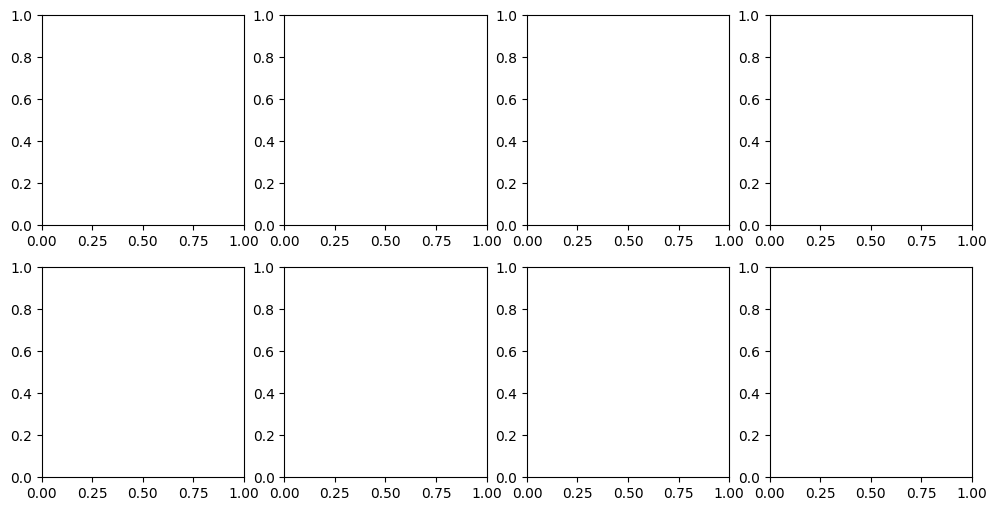

In [28]:
# Visualize samples from the fonts dataset
visualize_samples(fonts_train_dataset, num_samples=8, title="Fonts Dataset Samples")

# Examine a single sample
sample_idx = 0
image, label = fonts_train_dataset[sample_idx]

print(f"\nSample details:")
print(f"Image shape: {image.shape}")
print(f"Label: {label}")
print(f"Class name: {fonts_train_dataset.classes[label]}")

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sujaykapadnis/emotion-recognition-dataset")           # Data given in one folder unsplitted + csv

print("Path to dataset files:", path)

Image Segmentation

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("franciscoescobar/satellite-images-of-water-bodies")    # Binary Segmentation + unsplitted

print("Path to dataset files:", path)

100%|██████████| 247M/247M [00:05<00:00, 44.3MB/s]

Extracting files...


Path to dataset files: /content/data/datasets/franciscoescobar/satellite-images-of-water-bodies/versions/2


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("diversisai/fire-segmentation-image-dataset")            # Binary Segmentation + unsplitted

print("Path to dataset files:", path)

100%|██████████| 472M/472M [00:06<00:00, 74.7MB/s]

Extracting files...


Path to dataset files: /content/data/datasets/diversisai/fire-segmentation-image-dataset/versions/1


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("santurini/semantic-segmentation-drone-dataset")   # Multiclass segmentation + unsplitted

print("Path to dataset files:", path)

100%|██████████| 4.83G/4.83G [00:56<00:00, 91.5MB/s]

Extracting files...


Path to dataset files: /content/data/datasets/santurini/semantic-segmentation-drone-dataset/versions/2
